基礎的なnlpを行います。  
- mecabによる形態素解析  
- nlplotによる分析  

参考 : https://boxcode.jp/nlplot%E3%81%8C%E5%87%84%E3%81%84%EF%BC%81%E8%87%AA%E7%84%B6%E8%A8%80%E8%AA%9E%E3%82%92%E5%8F%AF%E8%A6%96%E5%8C%96%E3%83%BB%E5%88%86%E6%9E%90%E3%81%A7%E3%81%8D%E3%82%8Bpython%E3%83%A9%E3%82%A4

# params

In [23]:
class CFG:
  dic_dir = "/usr/local/lib/python3.10/dist-packages/unidic/dicdir" # MeCabの辞書が格納されている所
  filename_base = "jaran_fb"

# import/install

## install

In [2]:
# !git clone https://github.com/megagonlabs/jrte-corpus # sample dataのダウンロード

In [3]:
# !pip install mecab-python3

In [4]:
# !pip install unidic
# !python -m unidic download # MeCabで使用する辞書のinstall

In [5]:
# ! pip install nlplot

In [6]:
# ! pip install -U kaleido

## import

In [7]:
import pandas as pd

In [8]:
import MeCab 

In [9]:
import matplotlib.pyplot as plt

In [10]:
from plotly.offline import iplot

In [17]:
import nlplot 

# データロード  
今回はサンプルとしてじゃらんの宿評価データセットを用います。

In [11]:
df = pd.read_csv('./jrte-corpus/data/pn.tsv', delimiter='\t', header=None, names = ["id", "pn", "text", "categ", "categ_2"])
df = df[["id", "text"]]

In [12]:
df

,id,text
0,pn17q00001,出張でお世話になりました。
1,pn17q00002,朝食は普通でした。
2,pn17q00003,また是非行きたいです。
3,pn17q00004,また利用したいと思えるホテルでした。
4,pn17q00005,駅から近くて便利でした。
...,...,...
5548,pn17q05964,スクランブルエッグにとても大きな殻が入っていてざりざりして気持ちが悪く未だに思い出します。
5549,pn17q05965,何組か食事してましたが、明らかにレストランではないスペース。
5550,pn17q05967,静かで居心地も良いしまた行きたい宿になりましたが、一点だけ残念だったのが夕食の海鮮舟盛りです。
5551,pn17q05968,チェックインして、部屋に入るとベッドルームの照明の位置もわかりにくく、大変な思いをしました。


# 形態素解析  
MeCabによる形態素解析を実施します。

In [13]:
def pick_words(sample):
  '''
  文章を文字列形式で入力し、形態素解析した結果を品詞ごとにoutputします。  
  input
    sample[str] 形態素解析したい文字列

  output
    dict[str] 形態素解析された単語リスト
     dict.norm 
        sampleの中に含まれる名詞
     dict.verb
        sampleの中に含まれる動詞
     dict.adverb
        sampleの中に含まれる形容詞

  '''
  wakati = MeCab.Tagger("-d "+ CFG.dic_dir)
  node = wakati.parseToNode(sample)
  

  norm   = []
  adverb = []
  verb   = []

  while node:
  #名詞のみリストに格納する
    if node.feature.split(',')[0] == '名詞':
      norm.append(node.surface)
    #他の品詞を取得したければ、elifで追加する
    elif node.feature.split(',')[0] == '形容詞':
      adverb.append(node.surface)
    elif node.feature.split(',')[0] == '動詞':
      verb.append(node.surface)
    #    wordlist.append(node.surface)
    node = node.next

  return {
      "norm": norm,
      "adverb":adverb,
      "verb":verb
  }

In [51]:
# nlplotにinputできる形にデータを成形

df["norms"] = df["text"].apply(lambda x: pick_words(x)["norm"])
df["adverbs"] = df["text"].apply(lambda x: pick_words(x)["adverb"])
df["verbs"] = df["text"].apply(lambda x: pick_words(x)["verb"])
df["words"] = df["text"].apply(lambda x: pick_words(x)["norm"] + pick_words(x)["adverb"]) # 動詞まで含めるとみにくくなる（「する」など一般的すぎる動詞が邪魔になる。）ので除外

In [52]:
df = df[["text", "words"]]
df.head()

,text,words
0,出張でお世話になりました。,"[出張, 世話]"
1,朝食は普通でした。,"[朝食, 普通]"
2,また是非行きたいです。,[]
3,また利用したいと思えるホテルでした。,"[利用, ホテル]"
4,駅から近くて便利でした。,"[駅, 便利, 近く]"


# plotの作成

In [53]:
class PlotFigures:
  def __init__(self, sample):
    self.npt        = nlplot.NLPlot(sample, target_col='words')
    self.stopwords  = self.npt.get_stopword(top_n=0, min_freq=0)
    self.sample     = sample
    
  def bar_ngram(self):
    '''
    sampleデータをもとに、bar_ngramを作成します。
    作成された画像ファイルはCFG.filename_baseで指定されたディレクトリ下に作成
    (以下同様)
      input  なし
      output なし
    '''

    out = self.npt.bar_ngram(
        title = CFG.filename_base + " " + 'uni-gram',
        xaxis_label='word_count',
        yaxis_label='word',
        ngram=1,
        top_n=50,
        stopwords=self.stopwords
    )

    out.show()
    out.write_image(CFG.filename_base + "_" + "top_0.png")

  def tree_map(self):
    out = self.npt.treemap(
        title = CFG.filename_base + " " + 'Tree of Most Common Words',
        ngram=1,
        top_n=30,
        stopwords=self.stopwords,
    )

    out.show()
    out.write_image(CFG.filename_base + "_" + "tree_map.png")


  def word_distribution(self):
    out = self.npt.word_distribution(
    title=CFG.filename_base + " " + 'word distribution',
    xaxis_label='count'
    )

    out.show()
    out.write_image(CFG.filename_base + "_" + "word_distribution.png")

  def word_cloud(self):
    out = self.npt.wordcloud(
      #title=CFG.filename_base + " " + 'word cloud',
      max_words=100,
      max_font_size=100,
      colormap='tab20_r',
      stopwords=self.stopwords,
    )
    plt.figure(figsize=(15, 25))
    plt.imshow(out, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(CFG.filename_base + "_" + 'wordcloud.png',dpi = 300)
    plt.show()

  def co_network(self):
    self.npt.build_graph(stopwords=self.stopwords, min_edge_frequency=25)
    out = self.npt.co_network(
      title= CFG.filename_base + " " + 'Co-occurrence network',
      sizing=100,
      node_size='adjacency_frequency',
      color_palette='hls',
      width=1100,
      height=700,
      save=False
    )
    iplot(out)

  def fig_sunburst(self):
    out = self.npt.sunburst(
      title=CFG.filename_base + " " + 'sunburst chart',
      colorscale=True,
      color_continuous_scale='Oryel',
      width=1000,
      height=800,
      save=False
    )
    out.show()

    out.write_image(CFG.filename_base + "_" + "sunburst_chart.png")

In [54]:
pf = PlotFigures(df)

In [55]:
pf.bar_ngram()

100%|██████████| 5553/5553 [00:00<00:00, 102650.42it/s]


In [56]:
pf.tree_map()

100%|██████████| 5553/5553 [00:00<00:00, 181231.53it/s]


In [57]:
pf.word_distribution()

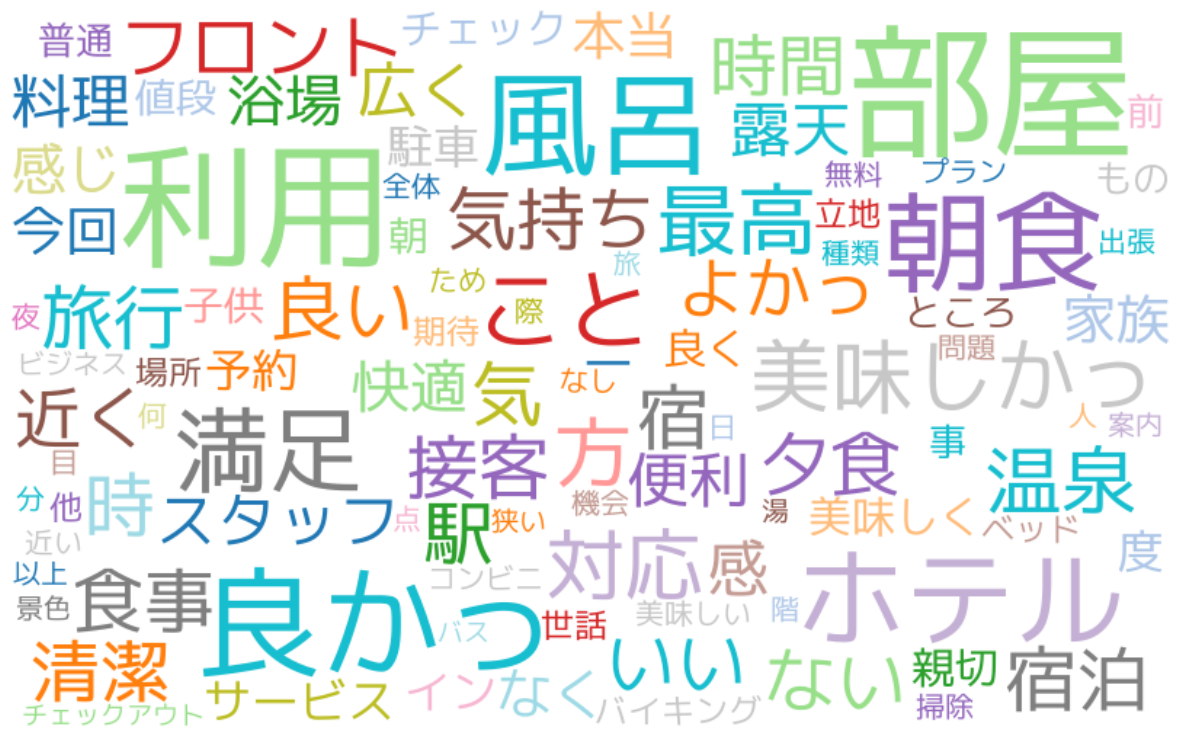

In [58]:
pf.word_cloud()

In [60]:
pf.co_network()

node_size:29, edge_size:25
